<h1><center> GCR SpecGen <a href="https://doi.org/10.5281/zenodo.2573359"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.2573359.svg" alt="DOI"></a></center></h1>

Welcome to GCR SpecGen!  This is a Jupyter notebook for conveniently generating Galactic Cosmic Ray (GCR) spectra as a function of source ion and solar modulation (which is a function of time) using [Daniel Matthiä's model (linked here)](https://www.sciencedirect.com/science/article/pii/S0273117712005947?via%3Dihub).  The spectra can be copied or downloaded as text files in a raw tab-delimited format or as source cards ready to be copied into a MCNP or PHITS input file.


### Setup instructions

There are a few steps you need to take before using this tool if this is your first session of this Jupyter notebook.  Above and on the right side of this body of text should be a small box which either says 'Trusted' or 'Not Trusted' inside it.  If this notebook is already trusted, then great!  If not, click the 'Not Trusted' box and confirm that you trust this notebook in the menu that appears.  This Jupyter notebook uses HTML and JavaScript for a few things to make using this notebook as clean an experience as possible and to allow cells, the individual units containing all of the code and UI elements below, to update by just pressing the buttons on the page (rather than having to manually run the cells), making this page usable by anyone regardless of their proficiency in any of these languages.

After the notebook is trusted, all of the following cells need to be initialized.  Either click the 'restart kernal and re-run whole notebook' button above ( &#9193; ) or run the first few cells manually by either clicking the 'Run' button above or pressing Shift+Enter a few times and then clicking the green "Initialize code" button below once it has been initialized.  This procedure will only need to be performed once for each time the Jupyter notebook is launched.

### A few notes on usage

The input source cards generated for PHITS and MCNP are designed for each GCR ion to be simulated independently.  While all source ions could be consolidated into a single input deck, the complexity in the reactions and cascades generated by each ion, the relative prominence of each ion, the significant difference in computational power required to simulate a complete history for each source ion, and differences in each use case in terms of desired results and available computational resources makes providing a universal solution to this nearly impossible.  To best optimize these factors, it is suggested to simulate each source GCR ion separately (for however many histories is deemed necessary for each) and to then combine tally results from each source ion in post, weighted by each source ion's relative fraction of the total GCR flux which is tabulated above the complete spectra.  

Additionally, these source cards are designed around MCNP6 and PHITS ver. 3.0; additional changes may be necessary for older versions of these codes.

#### W parameter
The value of the solar modulation parameter W can be automatically calculated when provided with a date or range of dates.  However, the sources of data for these W values varies depending on the date and are listed below.
* 1749/07-1964/04 -- W set equal to the [International Sunspot Number (ISSN)](http://www.sidc.be/silso/infosnmtot)
* 1964/05-1997/07 -- derived from [Oulu Neutron Monitor count rates](https://cosmicrays.oulu.fi/) as specified in [Matthiä et al.](https://www.sciencedirect.com/science/article/pii/S0273117712005947?via%3Dihub)
* 1997/08-2012/04 -- directly from [Matthiä et al.](https://www.sciencedirect.com/science/article/pii/S0273117712005947?via%3Dihub), derived from [ACE data](http://www.srl.caltech.edu/ACE/ASC/)
* 2012/05-2019/01 -- derived from [Oulu Neutron Monitor count rates](https://cosmicrays.oulu.fi/) as specified in [Matthiä et al.](https://www.sciencedirect.com/science/article/pii/S0273117712005947?via%3Dihub)

In [1]:
%matplotlib notebook
from IPython.display import HTML, display, Javascript, Math, clear_output
import numpy as np
import matplotlib.pyplot as plt
import re
import ipywidgets as w
import unicodedata as ud
import zipfile as zf
import datetime as dt
import time
#import tabulate

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<style>
 div.cell{
        width:100%;
        padding-top:0%;
        padding-bottom:0%;
        }
 .prompt {
    min-width: 10ex;}
</style>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')


In [2]:
'''
This code serves to quickly generate GCR spectra for ions with Z=1-28 using the Matthia model
https://www.sciencedirect.com/science/article/pii/S0273117712005947?via%3Dihub
'''

def slugify(value):
    """
    Normalizes string, converts to lowercase, removes non-alpha characters,
    and converts spaces to hyphens.
    """
    value = str(ud.normalize('NFKD', value).encode('ascii', 'ignore'))
    value = str(re.sub('[^\w\s-]', '', value).strip().lower())
    value = str(re.sub('[-\s]+', '-', value))
    return value

def on_click(change):
    #display(Javascript('IPython.notebook.execute_cells_below()'))  
    #display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    #display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, 6)'))
    display(Javascript('IPython.notebook.execute_cells'))

def on_click_run_all(change):
    display(Javascript('IPython.notebook.execute_cells_below()'))
    
def on_click_next(change):
    display(Javascript('IPython.notebook.execute_cells([IPython.notebook.get_selected_index()+1])'))

def on_click_calcs(change):
    display(Javascript('IPython.notebook.execute_cells([8,9,10,11])'))

def on_click_67(change):
    display(Javascript('IPython.notebook.execute_cells([10,11])'))

def gen_generic_save_file_button():
    generic_save_file_button = w.Button(
        description='Save file (txt)',
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Save a text file with information of the this spectrum ('+plotted_spectra_names[i][j]+') in the local text_files/ folder',
        icon='save' # pencil, rotate-right
    )
    return generic_save_file_button
    
def on_click_save_text_files(change):
    arc_fname = r'text_files/' + window_title + '.zip'
    zfile = zf.ZipFile(arc_fname, mode='w',compression=zf.ZIP_DEFLATED)
    for i in range(len(plotted_spectra_names)):
        for j in range(len(plotted_spectra_names[i])):
            txtname = plotted_spectra_names[i][j] + '.txt'
            zfile.writestr(txtname,plotted_spectra_text[i][j].replace('\n','\r\n'))
    zfile.close()
    update_print_str = 'ZIP archive of text files saved to: '+arc_fname
    print(update_print_str) # print saved note
    
def on_click_save_plot_pdf(change):
    global fig, window_title, update_print_str
    fname = r'images/'+window_title+'.pdf'
    fig.patch.set_alpha(0.0)
    fig.savefig(fname,facecolor=fig.get_facecolor())
    update_print_str = 'Plot saved to: '+fname
    print(update_print_str) # print saved note
    
def on_click_save_plot_png(change):
    global fig, window_title, update_print_str
    fname = r'images/'+window_title+'.png'
    fig.patch.set_alpha(0.0)
    fig.savefig(fname,facecolor=fig.get_facecolor())
    update_print_str = 'Plot saved to: '+fname
    print(update_print_str) # print saved note    
    
def on_click_save_plot_svg(change):
    global fig, window_title, update_print_str
    fname = r'images/'+window_title+'.svg'
    fig.patch.set_alpha(0.0)
    fig.savefig(fname,facecolor=fig.get_facecolor())
    update_print_str = 'Plot saved to: '+fname
    print(update_print_str) # print saved note
    
def on_click_save_plot_pdf2(change):
    global Wfig, window_title2, update_print_str
    fname = r'images/'+window_title2+'.pdf'
    Wfig.patch.set_alpha(0.0)
    Wfig.savefig(fname,facecolor=Wfig.get_facecolor())
    update_print_str = 'Plot saved to: '+fname
    print(update_print_str) # print saved note
    
def on_click_save_plot_png2(change):
    global Wfig, window_title2, update_print_str
    fname = r'images/'+window_title2+'.png'
    Wfig.patch.set_alpha(0.0)
    Wfig.savefig(fname,facecolor=Wfig.get_facecolor())
    update_print_str = 'Plot saved to: '+fname
    print(update_print_str) # print saved note    
    
def on_click_save_plot_svg2(change):
    global Wfig, window_title2, update_print_str
    fname = r'images/'+window_title2+'.svg'
    Wfig.patch.set_alpha(0.0)
    Wfig.savefig(fname,facecolor=Wfig.get_facecolor())
    update_print_str = 'Plot saved to: '+fname
    print(update_print_str) # print saved note

def on_click_reset_sliders(change):
    global fig_x_in, fig_y_in, default_fig_x_in, default_fig_y_in
    fig_x_in, fig_y_in = default_fig_x_in, default_fig_y_in
    display(Javascript('IPython.notebook.execute_cells([10])')) # refresh sliders
    
def on_click_zoom_out(change):
    global zoom_mult
    zoom_mult = 8
    update_print_str = 'Zoomed out!'
    display(Javascript('IPython.notebook.execute_cells([9])')) # redraw plot


def on_click_refresh_plot(change):
    global update_print_str, currently_updating_fig_dims
    update_print_str = 'Plot has been updated/refreshed!'
    display(Javascript('IPython.notebook.execute_cells([9])')) # update and redraw plot
    
def gen_all_none_buttons_v2():
    # uses actual Buttons
    global all_none_strings
    select_all = w.Button(
        description=all_none_strings[0],
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=all_none_strings,
    #     icons=['check'] * 5
    )
    select_none = w.Button(
        description=all_none_strings[1],
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=all_none_strings,
    #     icons=['check'] * 5
    )
    select_all_none = [select_all,select_none]
    return select_all_none

def on_click_set_checkF(change):
    global checkTF
    checkTF = False
    display(Javascript('IPython.notebook.execute_cells([IPython.notebook.get_selected_index()+1])'))

def on_click_set_checkT(change):
    global checkTF
    checkTF = True
    display(Javascript('IPython.notebook.execute_cells([IPython.notebook.get_selected_index()+1])'))
    
def on_click_sync_dates(change):
    global date_start, date_end
    date_end.value = date_start.value
    
def on_click_calc_W(change):
    global W_slider
    W_slider.value = calculate_W()
    

    
    
def toYearFraction(date):
    if date==None: return None
    
    day_of_year = dt.datetime.today().timetuple().tm_yday
    fraction = day_of_year/365

    return date.year + fraction
  
    
def calc_GCR_intensity(Z,W,E):
    '''
    Calculate GCR flux for a given ion at a given energy
    Inputs:
       - Z: GCR ion Z
       - W: solar modulation parameter
       - E: GCR ion energy (in MeV/n)
    Outputs: 
       - IOSI: ion flux in (s*sr*cm^2*MeV/n)^-1
    '''
    
    if Z<1 or Z>28 or W<0 or W>200:
        return -99
    if E<10:
        return 0
    
    AI = [1.0 ,4.0,  6.9,  9.0, 10.8, 12.0, 14.0, 16.0, 19.0, 20.2, 23.0, 24.3, 27.0, 28.1, 31.0, 32.1, 35.4, 39.9, 39.1, 40.1, 44.9, 47.9, 50.9, 52.0, 54.9, 55.8, 58.9, 58.7]
    CI = [1.85e4, 3.69e3, 19.5, 17.7, 49.2, 103.0, 36.7, 87.4, 3.19, 16.4, 4.4300, 19.300, 4.17, 13.4, 1.15, 3.060, 1.30, 2.33, 1.87, 2.17, 0.74, 2.63, 1.23, 2.12, 1.14, 9.32, 0.10, 0.48]
    gammaI = [2.74, 2.77, 2.82, 3.05, 2.96, 2.76, 2.89, 2.70, 2.82, 2.76, 2.84, 2.70, 2.77, 2.66, 2.89, 2.71, 3.00, 2.93, 3.05, 2.77, 2.97, 2.99, 2.94, 2.89, 2.74, 2.63, 2.63, 2.63]
    alphaI = [2.85, 3.12, 3.41, 4.30, 3.93, 3.18, 3.77, 3.11, 4.05, 3.11, 3.14, 3.65, 3.46, 3.00, 4.04, 3.30, 4.40, 4.33, 4.49, 2.93, 3.78, 3.79, 3.50, 3.28, 3.29, 3.01, 4.25, 3.52]
    
    P = [0.02,4.7]
    
    i = int(Z-1)
    
    E0S = 938.0 # rest mass in MeV/n
    if Z>1: E0S = 939.0 # rest mass in MeV/n
    E0SS = E0S/1000 # rest mass in GeV/n
    ES = E/1000 # energy in GeV/n
    RigS = (AI[i]/Z*np.sqrt(ES*(ES+2*E0SS))) #rigidity in GV
    betaS2 = (np.sqrt(ES*(ES+2.*E0SS))/(ES+E0SS)) #convert kinetic energy per nucleon to beta=v/c
    R0S = (0.37+0.0003*(W**1.45))
    DELTAI = (P[1]+P[0]*W)
    PHII = CI[i]*(betaS2**alphaI[i])/(RigS**gammaI[i])
    PHII = PHII*((RigS/(RigS+R0S))**DELTAI)
    IOSI = 0.0001*PHII*AI[i]/Z*0.001/betaS2
    
    return IOSI
    
def assemble_GCR_flux(W,nEbins=1000):
    '''
    Composes a NumPy array containing GCR flux from 10 MeV/n to 1 TeV/n for each GCR ion with Z=1-28
    Inputs:
       - W: solar modulation parameter
    Outputs:
       - GCR_flux(28,4,1000) - array containing flux values in (s*sr*cm^2*MeV/n)^-1 ; [emin/emid/emax/flux]
    '''
    GCR_flux = np.zeros((28,4,nEbins))
    
    Emin = 10 # MeV
    Emax = 1e6 # MeV
    
    logEmin = np.log10(Emin)
    logEmax = np.log10(Emax)
    logdE = (logEmax-logEmin)/nEbins
    logE = logEmin
    
    for k in range(nEbins):
        GCR_flux[:,0,k] = 10**(logE)
        GCR_flux[:,1,k] = 10**(logE+0.5*logdE)
        GCR_flux[:,2,k] = 10**(logE+logdE)
        logE += logdE
    
    for j in range(28):
        Z = j+1
        for k in range(nEbins):
            GCR_flux[j,3,k] = calc_GCR_intensity(Z,W,GCR_flux[j,1,k])
            
    return GCR_flux  


def calculate_W():
    global date_start, date_end, default_date, W_dates, W_values
    d1 = date_start.value
    d2 = date_end.value
    if d1 == None: d1 = default_date
    if d2 == None: d2 = d1
    
    d1_yr = toYearFraction(d1)
    d2_yr = toYearFraction(d2)
    
    if d1==d2:
        W_val = np.interp(d1_yr,W_dates,W_values)
    else:
        date_span = np.linspace(d1_yr,d2_yr,num=10)
        W_span = np.interp(date_span,W_dates,W_values)
        W_val = np.average(W_span)
        
    return W_val


# read in W values
W_dates = []
W_values = []
f = open('W_values.txt')
for line in f:
    vals = line.split()
    W_dates.append(np.float(vals[0]))
    W_values.append(np.float(vals[1]))
f.close()


# Source ion information
all_iso_strs = ['1H','4He','7Li','9Be','11B','12C','14N','16O','19F','20Ne','23Na','24Mg','27Al','28Si','31P','32S','35Cl','40Ar','39K','40Ca','45Sc','48Ti','51V','52Cr','55Mn','56Fe','59Co','59Ni']
all_iso_strs_TeX = [r'$^{1}_{1}$H',r'$^{4}_{2}$He',r'$^{7}_{3}$Li',r'$^{9}_{4}$Be',r'$^{11}_{5}$B',r'$^{12}_{6}$C',r'$^{14}_{7}$N',r'$^{16}_{8}$O',r'$^{19}_{9}$F',r'$^{20}_{10}$Ne',r'$^{23}_{11}$Na',r'$^{24}_{12}$Mg',r'$^{27}_{13}$Al',r'$^{28}_{14}$Si',r'$^{31}_{15}$P',r'$^{32}_{16}$S',r'$^{35}_{17}$Cl',r'$^{40}_{18}$Ar',r'$^{39}_{19}$K',r'$^{40}_{20}$Ca',r'$^{45}_{21}$Sc',r'$^{48}_{22}$Ti',r'$^{51}_{23}$V',r'$^{52}_{24}$Cr',r'$^{55}_{25}$Mn',r'$^{56}_{26}$Fe',r'$^{59}_{27}$Co',r'$^{59}_{28}$Ni']
all_Z_strs = ['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni']
A_list = [1,4,7,9,11,12,14,16,19,20,23,24,27,28,31,32,35,40,39,40,45,48,51,52,55,56,59,59]
Z_list = range(1,29)
ZZZAAA = []
for i in range(28):
    ZZZAAA.append("%03d" % Z_list[i] + "%03d" % A_list[i])

    
update_print_str = ""
checkTF = False # sets wether checkbox default state is True or False
currently_updating_fig_dims = False
zoom_mult = 1 # default zoom level to reset to
all_none_strings = ['Deselect All','Select All']
setup_run = True # condition for very first running of all cells
default_Z_on = [1,2,6,7,8,26]
default_date = dt.date(year=2012,month=1,day=31)


run_all_label = w.Label(value='(This button also resets everything in this code to its default state.)')

run_all_cells_button = w.Button(
    description='Initialize code',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to load all of the code cells if not already loaded.',
    icon='play' # pencil, rotate-right, paint-brush
)

display(w.HBox([run_all_cells_button,run_all_label]))
run_all_cells_button.on_click(on_click_run_all)


HBox(children=(Button(button_style='success', description='Initialize code', icon='play', style=ButtonStyle(), tooltip='Click to load all of the code cells if not already loaded.'), Label(value='(This button also resets everything in this code to its default state.)')))

In [3]:
display(HTML('<hr>'))
display(HTML('<h2>Input</h2>'))
display(HTML('<h3>GCR ion selection</h3>'))

ion_label = w.Label(value="Select GCR ion species of interest")
ion_an = gen_all_none_buttons_v2()
display(w.HBox([ion_label,ion_an[0],ion_an[1]]))
ion_an[0].on_click(on_click_set_checkF)
ion_an[1].on_click(on_click_set_checkT)

HBox(children=(Label(value='Select GCR ion species of interest'), Button(description='Deselect All', style=ButtonStyle()), Button(description='Select All', style=ButtonStyle())))

In [4]:
# Select ions of interest
ion_anb = checkTF

Z_strs= []

for i in range(28):
    Z_strs.append('Z='+str(i+1)+' ('+all_Z_strs[i]+')')

ions = [w.Checkbox(description=Z_strs[i],indent=False,value=ion_anb) for i in range(len(Z_strs))]

if setup_run: # set up default ions to be on
    for i in range(28):
        if (i+1) in default_Z_on:
            ions[i].value = True

ion_box1 = w.HBox((ions[0:7]),layout=w.Layout(width='130ex'))
ion_box2 = w.HBox((ions[7:14]),layout=w.Layout(width='130ex'))
ion_box3 = w.HBox((ions[14:21]),layout=w.Layout(width='130ex'))
ion_box4 = w.HBox((ions[21:28]),layout=w.Layout(width='130ex'))

display(w.VBox(([ion_box1, ion_box2, ion_box3, ion_box4])))

VBox(children=(HBox(children=(Checkbox(value=True, description='Z=1 (H)', indent=False), Checkbox(value=True, description='Z=2 (He)', indent=False), Checkbox(value=False, description='Z=3 (Li)', indent=False), Checkbox(value=False, description='Z=4 (Be)', indent=False), Checkbox(value=False, description='Z=5 (B)', indent=False), Checkbox(value=True, description='Z=6 (C)', indent=False), Checkbox(value=True, description='Z=7 (N)', indent=False)), layout=Layout(width='130ex')), HBox(children=(Checkbox(value=True, description='Z=8 (O)', indent=False), Checkbox(value=False, description='Z=9 (F)', indent=False), Checkbox(value=False, description='Z=10 (Ne)', indent=False), Checkbox(value=False, description='Z=11 (Na)', indent=False), Checkbox(value=False, description='Z=12 (Mg)', indent=False), Checkbox(value=False, description='Z=13 (Al)', indent=False), Checkbox(value=False, description='Z=14 (Si)', indent=False)), layout=Layout(width='130ex')), HBox(children=(Checkbox(value=False, description='Z=15 (P)', indent=False), Checkbox(value=False, description='Z=16 (S)', indent=False), Checkbox(value=False, description='Z=17 (Cl)', indent=False), Checkbox(value=False, description='Z=18 (Ar)', indent=False), Checkbox(value=False, description='Z=19 (K)', indent=False), Checkbox(value=False, description='Z=20 (Ca)', indent=False), Checkbox(value=False, description='Z=21 (Sc)', indent=False)), layout=Layout(width='130ex')), HBox(children=(Checkbox(value=False, description='Z=22 (Ti)', indent=False), Checkbox(value=False, description='Z=23 (V)', indent=False), Checkbox(value=False, description='Z=24 (Cr)', indent=False), Checkbox(value=False, description='Z=25 (Mn)', indent=False), Checkbox(value=True, description='Z=26 (Fe)', indent=False), Checkbox(value=False, description='Z=27 (Co)', indent=False), Checkbox(value=False, description='Z=28 (Ni)', indent=False)), layout=Layout(width='130ex'))))

In [5]:

#W = 50
#nEbins = 1000

E_text = w.IntText(value=100,step=1,layout=w.Layout(width='12%'))
E_label = w.Label(value='Select number of energy bins per spectrum')

display(w.HBox([E_label,E_text]))



display(HTML('<h3>Solar Modulation</h3>'))

date_start = w.DatePicker(
    description='Start date',
    #value=default_date,
    disabled=False
)

date_end = w.DatePicker(
    description='End date',
    disabled=False
)

date_same_button = w.Button(
    description='Same as start date',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to set end date equal to start date.',
    icon='' # pencil, rotate-right, paint-brush
)

calc_W_button = w.Button(
    description='Calculate W',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to calculate W over given date(s).',
    icon='calculator' # pencil, rotate-right, paint-brush
)


display(w.HBox([date_start,date_end,date_same_button,calc_W_button]))
date_same_button.on_click(on_click_sync_dates)
calc_W_button.on_click(on_click_calc_W)

W_slider = w.FloatSlider(
    description='W',
    min=0,
    max=300,
    step=10.0,
    value = 50,
)

W_text = w.FloatText(step=1.0,layout=w.Layout(width='12%'))

W_label = (w.Label(value="Select solar modulation parameter W"))

display(w.HBox([W_label,W_slider,W_text]))

w_link = w.jslink((W_slider, 'value'), (W_text, 'value'))


HBox(children=(Label(value='Select number of energy bins per spectrum'), IntText(value=100, layout=Layout(width='12%'))))

HBox(children=(DatePicker(value=None, description='Start date'), DatePicker(value=None, description='End date'), Button(description='Same as start date', style=ButtonStyle(), tooltip='Click to set end date equal to start date.'), Button(button_style='info', description='Calculate W', icon='calculator', style=ButtonStyle(), tooltip='Click to calculate W over given date(s).')))

HBox(children=(Label(value='Select solar modulation parameter W'), FloatSlider(value=50.0, description='W', max=300.0, step=10.0), FloatText(value=0.0, layout=Layout(width='12%'), step=1.0)))

<IPython.core.display.Javascript object>


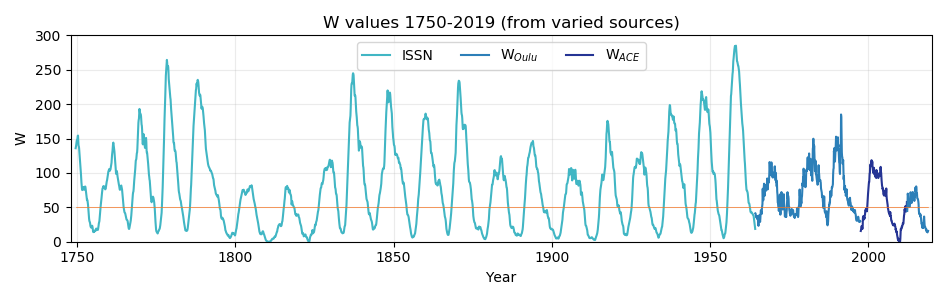

HBox(children=(Button(button_style='success', description='Save plot (PDF)', icon='save', style=ButtonStyle(), tooltip='Save plot as PDF in local images/ folder'), Button(button_style='success', description='Save plot (PNG)', icon='save', style=ButtonStyle(), tooltip='Save plot as PNG in local images/ folder'), Button(button_style='success', description='Save plot (SVG)', icon='save', style=ButtonStyle(), tooltip='Save plot as SVG in local images/ folder')))

In [6]:
c_ISSN = '#41b6c4'
c_Oulu = '#2c7fb8'
c_ACE  = '#253494'

xlim_vals = [1748,2020]
ylim_vals = [0,300]

Wfig, Wax = plt.subplots(nrows=1, ncols=1);
Wfig.set_size_inches(9.5,3)
Wax.plot(W_dates[:2578],W_values[:2578],c=c_ISSN,label=r'ISSN')
Wax.plot(W_dates[2578:2977],W_values[2578:2977],c=c_Oulu,label=r'W$_{Oulu}$')
Wax.plot(W_dates[2977:3175],W_values[2977:3175],c=c_ACE,label=r'W$_{ACE}$')
Wax.plot(W_dates[3175:-1],W_values[3175:-1],c=c_Oulu)

# W horizontal line
line, = Wax.plot([W_dates[0],W_dates[-1]],[50,50],c='#F67521',linewidth=0.5) 

# date vertical line(s)
d1_yr = toYearFraction(date_start.value)
d2_yr = toYearFraction(date_end.value)
d1_line, = Wax.plot([d1_yr,d1_yr],ylim_vals,c='#F67521',linewidth=0.5)
d2_line, = Wax.plot([d2_yr,d2_yr],ylim_vals,c='#F67521',linewidth=0.5)

Wax.set_xlabel('Year')
Wax.set_ylabel('W')
title_text = 'W values 1750-2019 (from varied sources)'
window_title2 = 'W_values'
plt.legend(loc='best',ncol=3)
plt.title(title_text)
plt.grid(b=True, which='major', linestyle='-', alpha=0.25)
plt.grid(b=True, which='minor', linestyle='-', alpha=0.10)
plt.xlim(xlim_vals)
plt.ylim(ylim_vals)
plt.tight_layout()

out = w.Output()

def myplot(n,d1,d2):
    with out:
        line.set_ydata(n)
        d1_line.set_xdata(toYearFraction(d1))
        d2_line.set_xdata(toYearFraction(d2))
        plt.tight_layout()
        display(Wfig)
        clear_output(wait=True)


def on_value_change(change):
    myplot(n=W_slider.value,d1=date_start.value,d2=date_end.value)

W_slider.observe(on_value_change)
#display(W_slider)


save_plot_button_pdf2 = w.Button(
    description='Save plot (PDF)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save plot as PDF in local images/ folder',
    icon='save' # pencil, rotate-right
)

save_plot_button_png2 = w.Button(
    description='Save plot (PNG)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save plot as PNG in local images/ folder',
    icon='save' # pencil, rotate-right
)

save_plot_button_svg2 = w.Button(
    description='Save plot (SVG)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save plot as SVG in local images/ folder',
    icon='save' # pencil, rotate-right
)

display(w.HBox([save_plot_button_pdf2,save_plot_button_png2,save_plot_button_svg2]))

save_plot_button_pdf2.on_click(on_click_save_plot_pdf2)
save_plot_button_png2.on_click(on_click_save_plot_png2)
save_plot_button_svg2.on_click(on_click_save_plot_svg2)



In [7]:
display(HTML('<hr>'))
display(HTML('<h3>Calculate spectra with updated parameters</h3>'))

make_plot_button = w.Button(
    description='Update values',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to redraw the plot below with updated options from above.',
    icon='refresh' # pencil, rotate-right, paint-brush, refresh
)

display(make_plot_button)
#display(make_plot_button)
make_plot_button.on_click(on_click_calcs)

display(HTML('<hr>'))

Button(button_style='success', description='Update values', icon='refresh', style=ButtonStyle(), tooltip='Click to redraw the plot below with updated options from above.')

In [8]:
# Collect and calculate values based on user input
display(HTML('<h2>Output</h2>'))

# Get number of energy bins
nEbins = E_text.value

# Determine ions of interest
zi_list = []
for i in range(28):
    if ions[i].value: zi_list.append(i)

# Get W
W = (W_slider.value)
W_text = ('{:g}'.format(W)).replace('.','p')

# Calculate GCR flux
GCR_flux = assemble_GCR_flux(W,nEbins)

integral_flux = []
for i in zi_list:
    integral_flux.append(np.sum(GCR_flux[i,3,:]*(GCR_flux[i,2,:]-GCR_flux[i,0,:])))
integral_flux = np.array(integral_flux)


setup_run = False

In [9]:
# Table

# Useful meta information
#   Total particle flux (by ion and total)

s_per_d = 60*60*24
s_per_y = 365.25*s_per_d

table = [['Z',r'A$^*$','ID',r'$\phi$ [#/(s$\cdot$sr$\cdot$cm$^2$)]',r'$\phi$ [#/(d$\cdot$sr$\cdot$cm$^2$)]',r'$\phi$ [#/(yr$\cdot$sr$\cdot$cm$^2$)]','Percent (%)']]
for i in range(len(zi_list)):
    zi = zi_list[i]
    table.append([str(zi+1),
                  str(A_list[zi]),
                  all_Z_strs[zi],
                  '{:.5E}'.format(integral_flux[i]),
                  '{:.5E}'.format(integral_flux[i]*s_per_d),
                  '{:.5E}'.format(integral_flux[i]*s_per_y),
                  '{:.4E}'.format(100*integral_flux[i]/np.sum(integral_flux))])
    
table.append(['','','All',
              '{:.5E}'.format(np.sum(integral_flux)),
              '{:.5E}'.format(np.sum(integral_flux)*s_per_d),
              '{:.5E}'.format(np.sum(integral_flux)*s_per_y),
              '{:.4E}'.format(100*np.sum(integral_flux)/np.sum(integral_flux))])
    
display(HTML('Integral GCR ion fluxes for W = {:g}'.format(W))) # $W={{{:}}}$'.format(str(W)))) # fancy W=XX text

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
       )
))

display(HTML(r'$^*$A = average atomic mass rounded to nearest integer'))


#display(HTML(tabulate.tabulate(table, tablefmt='html')))
#display(Math(all_iso_strs_TeX[7].replace('$','')))



Z,A$^*$,ID,$\phi$ [#/(s$\cdot$sr$\cdot$cm$^2$)],$\phi$ [#/(d$\cdot$sr$\cdot$cm$^2$)],$\phi$ [#/(yr$\cdot$sr$\cdot$cm$^2$)],Percent (%)
1,1,H,2.58577E-01,2.23411E+04,8.16008E+06,8.9952E+01
2,4,He,2.71427E-02,2.34513E+03,8.56559E+05,9.4422E+00
6,12,C,7.56739E-04,6.53822E+01,2.38809E+04,2.6325E-01
7,14,N,2.00612E-04,1.73329E+01,6.33084E+03,6.9788E-02
8,16,O,7.04545E-04,6.08727E+01,2.22337E+04,2.4509E-01
26,56,Fe,7.91415E-05,6.83782E+00,2.49752E+03,2.7531E-02
,,All,2.87461E-01,2.48366E+04,9.07158E+06,1.0000E+02


In [10]:
# Expandable menu with spectra (raw/PHITS/MCNP)

spectra_text_label = w.Label(value='For convenience, the GCR spectra can be viewed and saved in the tabs below.')
display(spectra_text_label)

plotted_spectra_text = [[],[],[]]
plotted_spectra_names = [[],[],[]]

ion_names = []
for i in zi_list:
    ion_names.append('Z-'+str(i+1)+'-'+all_Z_strs[i]+'_')
name_bases = ['All-Z-1-28_'] + ion_names

name_suffixes = ['raw','MCNP','PHITS']

column_headers = ['Emin [MeV/n]','Emid [MeV/n]','Emax [MeV/n]','Flux [#/(s*sr*cm^2*MeV/n)]']

for i in range(3):
    for j in range(len(zi_list)+1):
        if j!=0: zi = zi_list[j-1]
            
        if j==0 and i!=0: continue # skip combined files for MCNP and PHITS
        
        plotted_spectra_names[i].append('GCR-flux_W-' + W_text +'_'+ name_bases[j] + name_suffixes[i])
        
        if i==0: # raw spectra
            if j==0: # All ions
                text = "Flux F in units of [#/(s*sr*cm^2*MeV/n)]\n"
                text += column_headers[0]+'\t'+column_headers[1]+'\t'+column_headers[2]+'\t'
                for zii in zi_list:
                    text += 'F(Z={0}/{1})\t'.format(str(zii+1),all_Z_strs[zii])
                text = text[:-1]+'\n' # replace last tab with newline
                
                for ei in range(nEbins):
                    text += '{0:.8E}\t{1:.8E}\t{2:.8E}\t'.format(GCR_flux[0,0,ei],GCR_flux[0,1,ei],GCR_flux[0,2,ei])
                    for zii in zi_list:
                        text += '{0:.8E}\t'.format(GCR_flux[zii,3,ei])
                    text = text[:-1]+'\n' # replace last tab with newline
        
            if j!=0: # Individual ions
                text = ""
                text += column_headers[0]+'\t'+column_headers[1]+'\t'+column_headers[2]+'\t'+column_headers[3]+'\n'
                for ei in range(nEbins):
                    text += '{0:.8E}\t{1:.8E}\t{2:.8E}\t{3:.8E}\n'.format(GCR_flux[zi,0,ei],GCR_flux[zi,1,ei],GCR_flux[zi,2,ei],GCR_flux[zi,3,ei])
        
        if i==1: # MCNP spectra
            MCNP6_str =  'c Notes:' +  '\n'
            MCNP6_str += 'c   The listed energy bins should be ready to use for your application.' +  '\n'
            MCNP6_str += "c   This source term assumes a large spherical shell geometry for GCRs" + '\n'
            MCNP6_str += "c     isotropically impingent on a planet's atmosphere." + '\n'
            MCNP6_str += 'c   Change the geometric and angular portions of the source card to fit your usage.' + '\n'
            MCNP6_str += 'c ' +  '\n'
            MCNP6_str += 'c Source' +  '\n'
            MCNP6_str += ' SDEF PAR='+ZZZAAA[zi]+' ERG=D1 SUR=999 NRM = -1  AXS = 0 0 1  EXT = D90\n'
            MCNP6_str += ' SI90      -1 0 1           ' +  '\n'
            MCNP6_str += ' SP90      0 0.5 0.5        ' +  '\n'
            MCNP6_str += ' #  SI1      SP1' +  '\n'
            MCNP6_str += "    %.8E" % (GCR_flux[zi,0,0]*A_list[zi])+" 0.0 \n"
            for ei in range(nEbins):
                if ei==0: continue
                de = (GCR_flux[zi,2,ei]-GCR_flux[zi,2,ei-1])*A_list[zi]
                MCNP6_str += "    %.8E" % (GCR_flux[zi,2,ei]*A_list[zi]) +" %.8E" % (GCR_flux[zi,3,ei]*de) +'\n'
            text = MCNP6_str
        
        if i==2: # PHITS spectra
            PHITS_str =  '# Notes:' +  '\n'
            PHITS_str += "#   The entry 'iMeVperu = 1' must be set in your [PARAMETERS] card." + "\n"
            PHITS_str += '#   The listed energy bins should be ready to use for your application.' +  '\n'
            PHITS_str += "#   This source term assumes a large spherical shell geometry for GCRs" + '\n'
            PHITS_str += "#     isotropically impingent on a planet's atmosphere." + '\n'
            PHITS_str += '#   Change the geometric and angular portions of the source card to fit your usage.' + '\n'
            PHITS_str += '# ' +  '\n'
            PHITS_str += "[ S o u r c e ]" + "\n"
            PHITS_str += "   s-type =   9             # sperical shell source with energy distribution (should be =10 if using version before 2.94)" + "\n"
            PHITS_str += "     proj =   "+all_iso_strs[zi]+"       " + "\n"
            PHITS_str += "       r1 =   {:.8e}".format(3.48707700e8)+"   # inner radius [cm]" + "\n"
            PHITS_str += "       r2 =   {:.8e}".format(3.48707700e8)+"   # outer radius [cm]" + "\n"
            PHITS_str += "       x0 =   0.0000        # center position of x-axis [cm]" + "\n"
            PHITS_str += "       y0 =   0.0000        # center position of y-axis [cm]" + "\n"
            PHITS_str += "       z0 =   0.0000        # center position of z-axis [cm]" + "\n"
            PHITS_str += "      dir =   iso           # inward isotropic distribution" + "\n"
            PHITS_str += "   e-type =   21            # differential probability, dphi/dE" + "\n"
            PHITS_str += "       ne =   "+str(nEbins)+"          # number of energy bins" + "\n"
     
            for ei in range(nEbins):
                PHITS_str += "       %.8E" % (GCR_flux[zi,0,ei]) +' %.8E' % (GCR_flux[zi,3,ei]) +'\n'
            PHITS_str += "       %.8E" % (GCR_flux[zi,2,-1]) +'\n'
            text = PHITS_str
        
        
        plotted_spectra_text[i].append(text)
        
        
#print(mm_raw_text[0,2,0,0,0,0,0])

tab_names = ['Experiment','MCNP','PHITS']
tab_accordions = [[],[],[]]
accordions_list = []


save_file_buttons_list = [[],[],[]]

for i in range(len(plotted_spectra_names)):
    for j in range(len(plotted_spectra_names[i])):
        text = '<font size="2"><p style="line-height:1.4; font-family: monospace">' + plotted_spectra_text[i][j].replace('\n','<br>') + '</p></font>'
        textbox = w.HBox([w.HTML(value=text)], layout=w.Layout(height='400px', overflow_y='auto',width='1800px', overflow_x='auto'))
        
        save_file_buttons_list[i].append(gen_generic_save_file_button())
        #save_file_buttons_list[i][j].on_click(on_click_save_a_text_file)
        
        tab_accordions[i].append(w.VBox([textbox,save_file_buttons_list[i][j]]))
        
        
        
    temp_acc = w.Accordion(children=tab_accordions[i],selected_index=None) # ,layout=w.Layout(collapsed=True)
    for j in range(len(plotted_spectra_names[i])):
        temp_acc.set_title(j, plotted_spectra_names[i][j])
        
    accordions_list.append(temp_acc)


tab_nest = w.Tab()
tab_nest.children = accordions_list
tab_nest.set_title(0, tab_names[0])
tab_nest.set_title(1, tab_names[1])
tab_nest.set_title(2, tab_names[2])

display(tab_nest)

# Save individual files

# make individual save functions
save_funcions_array = [[],[],[]]
for i in range(len(plotted_spectra_names)):
    for j in range(len(plotted_spectra_names[i])):
        fname = r'text_files/' + plotted_spectra_names[i][j] + '.txt'
        fcontents = plotted_spectra_text[i][j]
        update_print_str = 'Text file saved to: '+ fname
        def function_builder(fname,fcontents,update_print_str):
            def on_click_save_a_text_file(change):
                f = open(fname,'w')
                f.write(fcontents)
                f.close()
                print(update_print_str) # print saved note
            return on_click_save_a_text_file
        save_funcions_array[i].append(function_builder(fname,fcontents,update_print_str))
        
        save_file_buttons_list[i][j].on_click(save_funcions_array[i][j])

# Save files in a ZIP archive

window_title = 'All_GCR_spectra_files'

save_text_button = w.Button(
    description='Save text (ZIP)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save text files of all GCR spectra in a ZIP archive in the local text_files/ folder',
    icon='save' # pencil, rotate-right
)

save_text_button.on_click(on_click_save_text_files)
save_text_extra_label = w.Label(value='(All above text files are archived into a single ZIP file when saved.)')

display(w.HBox([save_text_button,save_text_extra_label]))



Label(value='For convenience, the GCR spectra can be viewed and saved in the tabs below.')

Tab(children=(Accordion(children=(VBox(children=(HBox(children=(HTML(value='<font size="2"><p style="line-height:1.4; font-family: monospace">Flux F in units of [#/(s*sr*cm^2*MeV/n)]<br>Emin [MeV/n]\tEmid [MeV/n]\tEmax [MeV/n]\tF(Z=1/H)\tF(Z=2/He)\tF(Z=6/C)\tF(Z=7/N)\tF(Z=8/O)\tF(Z=26/Fe)<br>1.00000000E+01\t1.05925373E+01\t1.12201845E+01\t3.11230416E-06\t1.79107161E-06\t4.40374042E-08\t6.01217275E-09\t3.95803507E-08\t5.32311078E-09<br>1.12201845E+01\t1.18850223E+01\t1.25892541E+01\t3.78742143E-06\t2.10420044E-06\t5.19422577E-08\t7.27696652E-09\t4.66625657E-08\t6.23071859E-09<br>1.25892541E+01\t1.33352143E+01\t1.41253754E+01\t4.59188374E-06\t2.46022152E-06\t6.09719211E-08\t8.76487180E-09\t5.47485136E-08\t7.25777328E-09<br>1.41253754E+01\t1.49623566E+01\t1.58489319E+01\t5.54583448E-06\t2.86243295E-06\t7.12212475E-08\t1.05044602E-08\t6.39222511E-08\t8.41253311E-09<br>1.58489319E+01\t1.67880402E+01\t1.77827941E+01\t6.67135214E-06\t3.31384616E-06\t8.27792387E-08\t1.25254107E-08\t7.42625648E-08\t9.70230463E-09<br>1.77827941E+01\t1.88364909E+01\t1.99526231E+01\t7.99232213E-06\t3.81705061E-06\t9.57254993E-08\t1.48579038E-08\t8.58398391E-08\t1.11330802E-08<br>1.99526231E+01\t2.11348904E+01\t2.23872114E+01\t9.53420450E-06\t4.37406543E-06\t1.10126276E-07\t1.75318482E-08\t9.87125653E-08\t1.27091489E-08<br>2.23872114E+01\t2.37137371E+01\t2.51188643E+01\t1.13236770E-05\t4.98618082E-06\t1.26030144E-07\t2.05759277E-08\t1.12923548E-07\t1.44326902E-08<br>2.51188643E+01\t2.66072506E+01\t2.81838293E+01\t1.33881336E-05\t5.65379308E-06\t1.43463436E-07\t2.40164666E-08\t1.28495892E-07\t1.63033604E-08<br>2.81838293E+01\t2.98538262E+01\t3.16227766E+01\t1.57550197E-05\t6.37623820E-06\t1.62425523E-07\t2.78761129E-08\t1.45428872E-07\t1.83178867E-08<br>3.16227766E+01\t3.34965439E+01\t3.54813389E+01\t1.84509886E-05\t7.15162947E-06\t1.82884102E-07\t3.21723543E-08\t1.63693810E-07\t2.04696818E-08<br>3.54813389E+01\t3.75837404E+01\t3.98107171E+01\t2.15008690E-05\t7.97670592E-06\t2.04770651E-07\t3.69158875E-08\t1.83230124E-07\t2.27484962E-08<br>3.98107171E+01\t4.21696503E+01\t4.46683592E+01\t2.49264407E-05\t8.84669860E-06\t2.27976263E-07\t4.21088766E-08\t2.03941696E-07\t2.51401268E-08<br>4.46683592E+01\t4.73151259E+01\t5.01187234E+01\t2.87450241E-05\t9.75522272E-06\t2.52348060E-07\t4.77431500E-08\t2.25693768E-07\t2.76261984E-08<br>5.01187234E+01\t5.30884444E+01\t5.62341325E+01\t3.29679044E-05\t1.06942038E-05\t2.77686436E-07\t5.37984018E-08\t2.48310561E-07\t3.01840376E-08<br>5.62341325E+01\t5.95662144E+01\t6.30957344E+01\t3.75986215E-05\t1.16538464E-05\t3.03743375E-07\t6.02404781E-08\t2.71573832E-07\t3.27866584E-08<br>6.30957344E+01\t6.68343918E+01\t7.07945784E+01\t4.26311793E-05\t1.26226535E-05\t3.30222090E-07\t6.70198486E-08\t2.95222580E-07\t3.54028764E-08<br>7.07945784E+01\t7.49894209E+01\t7.94328235E+01\t4.80482424E-05\t1.35875054E-05\t3.56778257E-07\t7.40703803E-08\t3.18954128E-07\t3.79975695E-08<br>7.94328235E+01\t8.41395142E+01\t8.91250938E+01\t5.38194108E-05\t1.45338044E-05\t3.83023063E-07\t8.13085418E-08\t3.42426781E-07\t4.05320995E-08<br>8.91250938E+01\t9.44060876E+01\t1.00000000E+02\t5.98996836E-05\t1.54456923E-05\t4.08528302E-07\t8.86331831E-08\t3.65264231E-07\t4.29649054E-08<br>1.00000000E+02\t1.05925373E+02\t1.12201845E+02\t6.62282401E-05\t1.63063447E-05\t4.32833680E-07\t9.59260368E-08\t3.87061876E-07\t4.52522791E-08<br>1.12201845E+02\t1.18850223E+02\t1.25892541E+02\t7.27276826E-05\t1.70983441E-05\t4.55456447E-07\t1.03053083E-07\t4.07395124E-07\t4.73493220E-08<br>1.25892541E+02\t1.33352143E+02\t1.41253754E+02\t7.93038921E-05\t1.78041307E-05\t4.75903361E-07\t1.09866907E-07\t4.25829710E-07\t4.92110807E-08<br>1.41253754E+02\t1.49623566E+02\t1.58489319E+02\t8.58466508E-05\t1.84065244E-05\t4.93684898E-07\t1.16210135E-07\t4.41933939E-07\t5.07938441E-08<br>1.58489319E+02\t1.67880402E+02\t1.77827941E+02\t9.22311664E-05\t1.88893082E-05\t5.08331446E-07\t1.21920002E-07\t4.55292643E-07\t5.20565777E-08<br>1.77827941E+02\t1.88364909E+02\t1.99526231E+02\t9.8320610

HBox(children=(Button(button_style='success', description='Save text (ZIP)', icon='save', style=ButtonStyle(), tooltip='Save text files of all GCR spectra in a ZIP archive in the local text_files/ folder'), Label(value='(All above text files are archived into a single ZIP file when saved.)')))

<IPython.core.display.Javascript object>


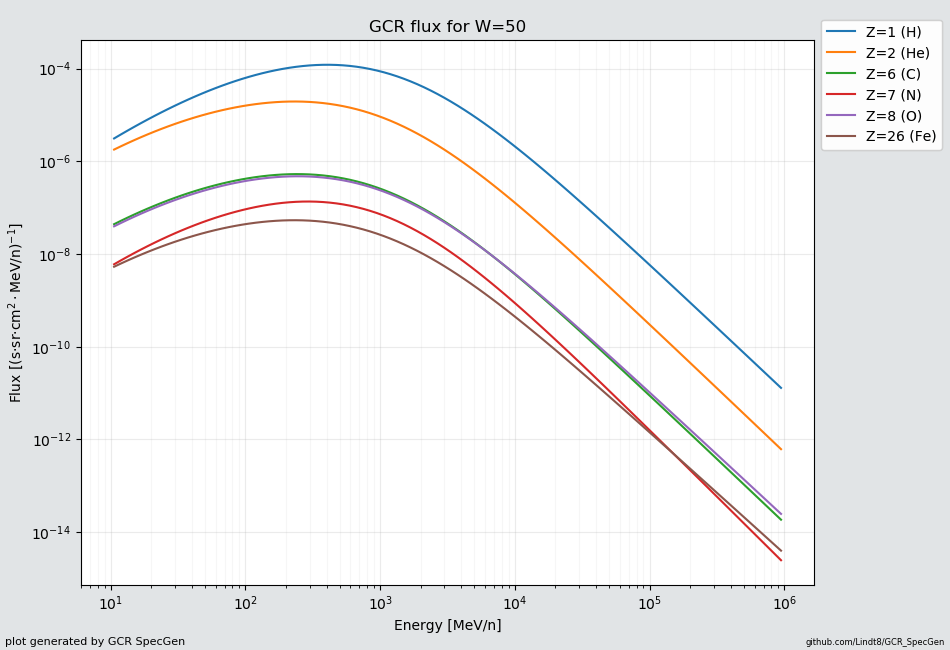

In [11]:
# Plotting

fig = plt.figure()
bg_color = '#E1E4E6'
fig.patch.set_facecolor(bg_color)
fig.patch.set_alpha(1.0)
l_corner_logo_text = 'plot generated by GCR SpecGen'
l_corner_logo_fs = 8
r_corner_logo_text = 'github.com/Lindt8/GCR_SpecGen'
r_corner_logo_fs = 6
fig.text(0.005,0.005,l_corner_logo_text,fontsize=l_corner_logo_fs,horizontalalignment='left',verticalalignment='bottom')
fig.text(0.995,0.005,r_corner_logo_text,fontsize=r_corner_logo_fs,horizontalalignment='right',verticalalignment='bottom')
ax = plt.subplot(111)
for i in range(28):
    if i not in zi_list: continue
    Z = i+1
    legstr = 'Z='+str(Z)+' (' + all_Z_strs[i] + ')' # all_iso_strs_TeX[i]
    plt.plot(GCR_flux[i,1,:],GCR_flux[i,3,:],label=legstr)


# hangle figure/legend positioning/sizing
# First, figure size
default_fig_x_in = 9.5
default_fig_y_in = 6.5

# first, try getting widget widths from below; otherwise, use defaults
if currently_updating_fig_dims:
    fig_x_in = adjust_w_slider.value
    fig_y_in = adjust_h_slider.value
else:
    fig_x_in = default_fig_x_in
    fig_y_in = default_fig_y_in

fig.set_size_inches(fig_x_in,fig_y_in)
    
legend_type = 'outside_right'
if legend_type == 'outside_right':
    # Add primary legend
    leg1_anchor = (1.0, 1.05) # varied items 
    handles_l1, labels_l1 = ax.get_legend_handles_labels()
    # remove the errorbars
    if len(handles_l1)>0:
        handles_l1 = [h for h in handles_l1]
        legend1 = ax.legend(handles_l1, labels_l1,loc='upper left',bbox_to_anchor=leg1_anchor,ncol=1)
        ax.add_artist(legend1)
        # Change marker in legend
        #for l in legend1.get_lines():
        #    #l.set_alpha(1)
        #    l._legmarker.set_marker('s')
        #    l._legmarker.set_markersize(12)
    

good_to_go = True
if good_to_go: # stuff that will error out code on first initialization
    fig.canvas.draw()
    f1 = legend1.get_frame()
    l1_w0_px, l1_h0_px = f1.get_width(), f1.get_height()
    l_w0_in, l_h0_in = l1_w0_px/fig.dpi, l1_h0_px/fig.dpi # max legend dimensions in inches
    
    # Determine relative dimensions of plot
    x0bar = 0.8075 # inches, horizontal space needed for ylabel
    y0bar = 0.6500 # inches, vertical space needed for xlabel alone
    t0bar = 0.4000 # inches, vertical space needed for title
    del_l_in = 0.15 # inches, extra horizontal padding right of legend

    x0 = x0bar/fig_x_in
    y0 = y0bar/fig_y_in
    h0 = 1 - (y0bar+t0bar)/fig_y_in
    w0 = 1 - x0 - (l_w0_in/fig_x_in) - (del_l_in/fig_x_in)
    
    # Set size and location of the plot on the canvas
    box = ax.get_position()
    # all vals in [0,1]: left, bottom, width, height
    ax.set_position([x0, y0, w0, h0])
    
    
plt.xlabel('Energy [MeV/n]')
plt.ylabel(r'Flux [(s$\cdot$sr$\cdot$cm$^2\cdot$MeV/n)$^{-1}$]')
title_text = 'GCR flux for W={:g}'.format(W)
plt.title(title_text)
#plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
plt.grid(b=True, which='major', linestyle='-', alpha=0.25)
plt.grid(b=True, which='minor', linestyle='-', alpha=0.10)
plt.show()

In [12]:
save_plot_button_pdf = w.Button(
    description='Save plot (PDF)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save plot as PDF in local images/ folder',
    icon='save' # pencil, rotate-right
)

save_plot_button_png = w.Button(
    description='Save plot (PNG)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save plot as PNG in local images/ folder',
    icon='save' # pencil, rotate-right
)

save_plot_button_svg = w.Button(
    description='Save plot (SVG)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save plot as SVG in local images/ folder',
    icon='save' # pencil, rotate-right
)


currently_updating_fig_dims = True
adjust_label = w.Label(value="Adjust figure dimensions via sliders or text boxes (all units in inches, minimum dimension = 1\", maximum dimension = 10\").")

adjust_w_slider = w.FloatSlider(
    description='width (in.)',
    min=1,
    max=10,
    value = fig_x_in,
)
adjust_w_text = w.FloatText(step=0.1)

adjust_h_slider = w.FloatSlider(
    description='height (in.)',
    min=1,
    max=10,
    value = fig_y_in,
)

reset_sliders_button = w.Button(
    description='Reset sliders',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to reset sliders to default values.',
    icon='exclamation' # pencil, rotate-right, paint-brush
)
adjust_h_text = w.FloatText(step=0.1)

refresh_plot_button2 = w.Button(
    description='Refresh plot',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to redraw the plot with updated dimensions.',
    icon='refresh' # pencil, rotate-right, paint-brush
)

zoom_mult = 1 # reset zoom value
zoom_out_label = w.Label(value='Zooming in can be freely done within the interactive plot.  This button zooms out the default view.')
zoom_out_button = w.Button(
    description='Zoom out',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='While you can freely zoom in to any rectangle on the interactive plot, there is no way to zoom out from the starting view.  This solves that issue.',
    icon='search-minus' # pencil, rotate-right
)

display(w.HBox([zoom_out_label,zoom_out_button]))
zoom_out_button.on_click(on_click_zoom_out)

display(adjust_label)
display(w.HBox([adjust_w_slider,adjust_h_slider,reset_sliders_button,refresh_plot_button2]))
display(w.HBox([adjust_w_text,adjust_h_text]))
w_link = w.jslink((adjust_w_slider, 'value'), (adjust_w_text, 'value'))
h_link = w.jslink((adjust_h_slider, 'value'), (adjust_h_text, 'value'))
reset_sliders_button.on_click(on_click_reset_sliders)
refresh_plot_button2.on_click(on_click_refresh_plot)

#PDF_box = w.HBox([PDF_label,save_plot_button,save_plot_button_wbg],layout=w.Layout(width='380px')) 
#PNG_box = w.HBox([PNG_label,save_plot_button_png,save_plot_button_wbg_png])
#save_buttons_box = w.Box([PDF_box,PNG_box])
#save_buttons_box.layout.justify_content='space-around'
display(w.HBox([save_plot_button_pdf,save_plot_button_png,save_plot_button_svg]))

save_plot_button_pdf.on_click(on_click_save_plot_pdf)
save_plot_button_png.on_click(on_click_save_plot_png)
save_plot_button_svg.on_click(on_click_save_plot_svg)

HBox(children=(Label(value='Zooming in can be freely done within the interactive plot.  This button zooms out the default view.'), Button(description='Zoom out', icon='search-minus', style=ButtonStyle(), tooltip='While you can freely zoom in to any rectangle on the interactive plot, there is no way to zoom out from the starting view.  This solves that issue.')))

Label(value='Adjust figure dimensions via sliders or text boxes (all units in inches, minimum dimension = 1", maximum dimension = 10").')

HBox(children=(FloatSlider(value=9.5, description='width (in.)', max=10.0, min=1.0), FloatSlider(value=6.5, description='height (in.)', max=10.0, min=1.0), Button(button_style='info', description='Reset sliders', icon='exclamation', style=ButtonStyle(), tooltip='Click to reset sliders to default values.'), Button(button_style='success', description='Refresh plot', icon='refresh', style=ButtonStyle(), tooltip='Click to redraw the plot with updated dimensions.')))

HBox(children=(FloatText(value=0.0, step=0.1), FloatText(value=0.0, step=0.1)))

HBox(children=(Button(button_style='success', description='Save plot (PDF)', icon='save', style=ButtonStyle(), tooltip='Save plot as PDF in local images/ folder'), Button(button_style='success', description='Save plot (PNG)', icon='save', style=ButtonStyle(), tooltip='Save plot as PNG in local images/ folder'), Button(button_style='success', description='Save plot (SVG)', icon='save', style=ButtonStyle(), tooltip='Save plot as SVG in local images/ folder')))

### Special notes on saving plots and text files

##### For users online on the Binder build of this notebook:

The save buttons will generate the PDFs/PNGs/SVGs in the [``images``](images/) folder of the repository window (the page on which you clicked the ``SHAEDIT.ipynb`` link to arrive here), but you must download them locally yourself before you leave the site because they will be erased once your Binder session is ended.  

The plots can also be saved directly to your computer as a PNGs (regardless of where you are viewing the data from), by clicking the little power button ( &#9211; ) in the top right of the figure, right clicking the image, and then clicking "Save image as..." to save it to a local folder. 

Any saved text files or ZIP archives will be stored in the [``text_files``](text_files/) folder of the repository window, and you must manually download any files from that folder before leaving the site if you wish to keep them since they will otherwise be deleted automatically once the session is ended. 

Files can be downloaded from the repository window (and its folders) by checking the checkbox(es) to the left of the file(s) you wish to download and then clicking the Download button above the files interface.

##### For users viewing this notebook locally:
You will know if you are viewing this locally since it would had required downloading this whole repository and installing python, jupyter, and all libraries this notebook depends on.  Additionally, your URL should look something like ``localhost:8888/notebooks/GCR%20SpecGen.ipynb`` if viewing locally.

If you wish to save a plot with the above buttons, you must create a folder titled [``images``](images/) within the main directory which holds this notebook and the data files it relies on; plots will be saved in that [``images``](images/) folder with descriptive filenames resembling the plot title.   

Likewise, for saving individual text files or ZIP archives of all plotted files, you must generate a [``text_files``](text_files/) folder within the main directory containing this notebook.


### Binder session duration information (relevant to online viewing only)

Binder sessions will automatically close (deleting all extra files generated by this code) if it detects 10 minutes of inactivity, though [the Binder FAQ](https://mybinder.readthedocs.io/en/latest/faq.html#how-long-will-my-binder-session-last) states that keeping the window open serves as staying active.  Since a lost connection can cause Binder to believe this notebook is no longer active, resulting in it being closed, it is advisable that any files generated with the Save buttons ( &#128190; ) are downloaded from their subdirectories ([``images``](images/) and/or [``text_files``](text_files/)) of the main repository window in the same sitting in which they were generated.  

Additionally, while it may be possible for a Binder session to remain open for a long time, it is suggested to close the notebook tabs when done and then reload the notebook at the start of each sitting by visiting https://mybinder.org/v2/gh/Lindt8/GCR_SpecGen/master, allowing Binder to build the most up-to-date version of this code.

<center>GCR SpecGen was written by Hunter Ratliff at the University of Tennessee, Knoxville, Department of Nuclear Engineering. <br />
    Copyright &#169; 2018 Hunter Ratliff (Lindt8)  [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.2573359.svg)](https://doi.org/10.5281/zenodo.2573359)</center> 
    